# 5장

### 역전파시 MatMul 노드를 지날때 기울기의 변화(실험 1)

In [6]:
import warnings

In [7]:
warnings.filterwarnings('ignore')

In [17]:
import matplotlib.pyplot as plt
#matplotlib 패키지 한글 깨짐 처리 시작
# plt.rc('font', family='Malgun Gothic') #윈도우, 구글 콜랩
plt.rc('font', family='AppleGothic') #맥
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결
#matplotlib 패키지 한글 깨짐 처리 끝

In [25]:
import numpy as np
import matplotlib.pyplot as plt

N = 2  # 미니배치 크기
H = 3  # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3) # 재현을 위해 난수 시드 고정
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

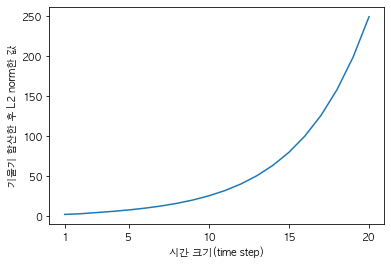

In [26]:
# print('* norm_list:\n', norm_list)
plt.plot(np.arange(len(norm_list)), norm_list)  # plt.plot(x, y)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('기울기 합산한 후 L2 norm한 값')
plt.show()

### 역전파시 MatMul 노드를 지날때 기울기의 변화(실험 2)

In [23]:
import numpy as np
import matplotlib.pyplot as plt

N = 2  # 미니배치 크기
H = 3  # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3) # 재현을 위해 난수 시드 고정
# Wh = np.random.randn(H, H)     # 변경 전
Wh = np.random.randn(H, H) * 0.5 # 변경 후

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

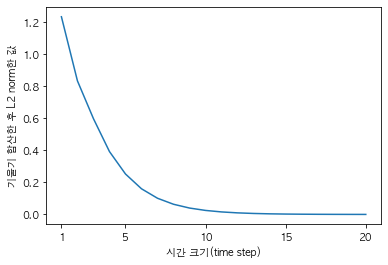

In [24]:
# print('* norm_list:\n', norm_list)
plt.plot(np.arange(len(norm_list)), norm_list)  # plt.plot(x, y)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('기울기 합산한 후 L2 norm한 값')
plt.show()

### 기울기 클리핑(gradient clipping)

In [27]:
import numpy as np

dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

### LSTM

In [29]:
# 총 4개의 게이트의 각 Wx, Wh, b 파라미터를 결합해 Affine 변환으로 한 번에 계산!
class LSTM:
    """ 단일 LSTM 계층 클래스 구현
    
    Args:
        Wx: 4개의 게이트에서 각각 입력 벡터 Xt 에 곱해지는 파라미터 Wx 4개
        Wh: 4개의 게이트에서 각각 이전 은닉 상태 벡터 h_t-1 에 곱해지는 파라미터 Wh 4개
        b: 4개의 게이트에서 각각 더해지는 편향 b 파라미터 4개
    
    """
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape  # 은닉 상태 벡터 차원 수 (batch_size, 노드 수)
        
        # 총 4개의 게이트에서의 아핀 변환을 한 번에 계산
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        # slicing 해서 각 게이트에 보내기
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = np.tanh(c_next) * o
        
        self.cache = (x, h_prev, c_prev, f, g, i, o, c_next) # 역전파 시 사용할 데이터들 캐싱해두기
        return h_next, c_next
    
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, f, g, i, o, c_next = self.cache
        #===============
        # 게이트 역전파 수행
        #===============
        tanh_c_next = np.tanh(c_next)
        
        ds = dh_next * o * (1 - tanh_c_next**2) + dc_next
        
        dc_prev = ds * f  # 이전 기억 셀의 기울기
        
        # output 게이트
        do = dh_next * tanh_c_next
        do *= o * (1 - o)
        # input 게이트
        di = ds * g
        di *= i * (1 - i)
        # 새로운 기억 셀(main 게이트)
        dg = ds * i
        dg *= (1 - g**2)
        # forget 게이트
        df = ds * c_prev
        df *= f * (1 - f)
        
        # 4개 게이트 기울기 가로로 결합, horizontal stack
        dA = np.hstack((df, dg, di, do))
        
        #=================================
        # Affine 변환(행렬 곱)에 대한 역전파 수행
        #=================================
        # 파라미터 기울기 계산
        dWx = np.matmul(x.T, dA)
        dWh = np.matmul(h_prev.T, dA)
        db = dA.sum(axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        # 입력, 은닉상태 벡터 기울기 계싼
        dx = np.matmul(dA, Wx.T)
        dh_prev = np.matmul(dA, Wh.T)
        
        return dx, dh_prev, dc_prev

### time LSTM

In [31]:
# T 길이의 시계열 데이터를 한번에 처리하는 LSTM 계층
class TimeLSTM:
    """ 단일 LSTM 계층이 T개 있는 TimeLSTM 계층 구현
    
    Args:
        Wx: 입력 벡터 x에 곱해지는 파라미터
        Wh: 이전 LSTM 계층으로부터 흘러들어오는 은닉 상태 벡터 h에 곱해지는 파라미터
        b: 편향 파라미터
        stateful: 은닉 상태를 유지할지 여부. 유지하면 Truncated BPTT 수행 시 순전파를 끊지 않고 전달
        
    """
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = []
        
        self.h, self.c = None, None   # 은닉상태벡터, 기억셀
        self.dh = None                # 이전 블록의 은닉 상태 기울기 값(이는 Truncated BPTT에서는 필요없지만 seq2seq에서 필요하기 때문이라고 함)
        self.stateful = stateful
    
    def forward(self, xs):
        """ xs라는 T 길이의 시계열 전체 입력 벡터를 순전파 수행
        
        Args:
            xs: T 길이의 시계열 전체 입력 벡터
            
        """
        Wx, Wh, b = self.params
        N, T, D = xs.shape       # (batch_size, time length, 입력벡터 차원 수)
        H = Wh.shape[0]          # 은닉상태 벡터 차원 수
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')  # T 길이의 LSTM 계층 전체의 은닉 상태 벡터를 담을 배열 초기화
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)  # loop다 돌면 마지막 은닉상태,기억셀이 들어있음!
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    
    def backward(self, dhs):
        """ T길이의 시계열 전체를 한 번에 Truncated BPTT 수행
        
        Args:
            dhs: T길이 시계열 내의 모든 은닉 상태 벡터의 기울기
        
        """
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]  # 입력 벡터 차원 수
        
        dxs = np.empty((N, T, D), dtype='f') # T길이 시계열 내의 모든 입력 벡터의 기울기
        dh, dc = 0, 0
        
        grads = [0, 0, 0] # 하나의 LSTM 계층에서 Wx, Wh, b 파라미터의 기울기 담을 리스트
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)  # dh는 분기의 역전파므로 sum
            dxs[:, t, :] = dx
            
            # 하나의 LSTM 계층에서 Wx, Wh, b 파라미터의 기울기 담기
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        
        # T길이 시계열 전체의 LSTM 계층에 걸쳐서 만들어진 Wx, Wh, b 파라미터 기울기 담기
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            
        self.dh = dh  # 역전파 방향으로 보았을 때의 마지막 은닉 상태 벡터 기울기 값 캐싱 for seq2seq
        
        return dxs
    
    # 은닉상태, 기억셀 설정 함수
    def set_state(self, h, c=None):
        self.h, self.c = h, c
    
    # 은닉상태, 기억셀 초기화하여 순전파 시에도 유지 끊어버리기
    def reset_state(self):
        self.h, self.c = None, None

### 언어모델(Rnnlm)

In [32]:
import numpy as np
from common.time_layers import *
import pickle


class Rnnlm:
    """ LSTM 계층 사용한 언어 생성 모델
    
    Args:
        vocab_size: 주어진 말뭉치 내 unique한 단어 개수(Vocabulary size)
        wordvec_size: One-hot으로 되어있는 Sparse 입력 단어를 몇 차원 임베딩 Dense 벡터로 줄일 것인지
        hidden_size: LSTM 계층 내의 은닉 상태 벡터 차원 수(노드 수)
    
    """
    def __init__(self, vocab_size=10000, word_vec=100, hidden_size=100):
        V, D, H = vocab_size, word_vec, hidden_size
        rn = np.random.randn
        
        #===========
        # 가중치 초기화
        #===========
        # 1. 임베딩 계층
        embed_W = (rn(V, D) / 100).astype('f')
        # 2. LSTM 계층
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        # 3. Affine 계층
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        
        # 계층 생성
        self.layers = [TimeEmbedding(embed_W),
                       TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
                       TimeAffine(affine_W, affine_b)]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]  # 추후에 은닉상태, 기억 셀 유지 끊는 함수 구현 위해 캐싱해두기
        
        
        # 모든 계층의 파라미터 취합
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
            
    # 순전파 수행 후 예측값 반환
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    
    # 순전파 수행(predict 메소드) 및 Loss 계산
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    
    # 역전파 수행
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    
    def reset_state(self):
        self.lstm_layer.reset_state()
    
    
    # 학습한 파라미터 저장 및 로드 메소드
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)